In [75]:
# use the python package pyet to calculate the ETP based on the penman montheit equation 
# perform sensitivity analysis

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import pyet
import numpy as np
from scipy import stats

In [77]:
#read data
data_16412 = pd.read_csv('klima_daily.csv', index_col=1, parse_dates=True)
data_16412

,station,strahl,rel,t,tmax,tmin,vv
time,,,,,,,
2000-01-01,16412,300.0,80.0,-2.7,0.5,-5.8,1.0
2000-01-02,16412,250.0,86.0,0.2,2.5,-2.1,1.0
2000-01-03,16412,598.0,86.0,0.6,3.6,-2.4,1.0
2000-01-04,16412,619.0,83.0,-0.5,4.5,-5.5,1.0
2000-01-05,16412,463.0,84.0,-0.1,5.4,-5.5,1.0
...,...,...,...,...,...,...,...
2021-11-07,16412,852.0,74.0,8.5,12.2,4.7,1.6
2021-11-08,16412,553.0,78.0,7.5,10.4,4.5,1.6
2021-11-09,16412,902.0,67.0,7.1,11.7,2.4,2.7


## Calculate PET for Graz Universität - 16412

In [78]:
# Convert Glabalstrahlung J/cm2 to MJ/m2 by dividing to 100

meteo = pd.DataFrame({"time":data_16412.index, "tmean":data_16412.t, "tmax":data_16412.tmax, "tmin":data_16412.tmin, "rh":data_16412.rel, 
                      "wind":data_16412.vv, "rs":data_16412.strahl/100})
time, tmean, tmax, tmin, rh, wind, rs = [meteo[col] for col in meteo.columns]

lat = 47.077778*np.pi/180  # Latitude of the meteorological station, converting from degrees to radians
elevation = 367  # meters above sea-level

lambda1=pyet.calc_lambda(tmean=tmean)  # Latent Heat of Vaporization in PyEt [MJ kg-1] 
lambda0 = 2.45  # Latent Heat of Vaporization in Guo et al., 2016 [MJ kg-1] 
lambda_corr = lambda1 / lambda0  # Correction factor

In [79]:
pyet_penman = pyet.penman(tmean, wind, rs=rs, elevation=elevation, lat=lat, tmax=tmax, 
                          tmin=tmin, rh=rh, aw=1, bw=0.526, albedo=0.08) * lambda_corr

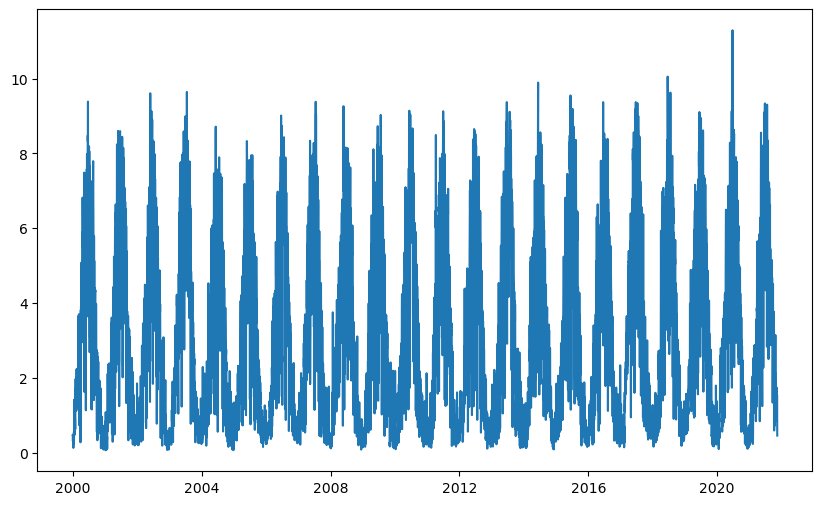

In [80]:
# plot pyet_penman
fig, ax = plt.subplots(figsize = (10,6))

ax.plot(pyet_penman)

In [81]:
# perform sensitivity analysis
# create random distributed data for the parameters

t_min = (min(tmin), max(tmin))
t_max = (min(tmax), max(tmax))
t_mean = (min(tmean), max(tmean))
wind_mm = (min(wind), max(wind))
rs_mm = (min(rs), max(rs))
rh_mm = (min(rh), max(rh))

temp_range = (t_mean[0], t_mean[1])
tmin_range = (t_min[0], t_min[1])
tmax_range = (t_max[0], t_max[1])
wind_range = (wind_mm[0], wind_mm[1])
rs_range = (rs_mm[0], rs_mm[1])
rh_range = (rh_mm[0], rh_mm[1])

wind_range = np.linspace(0.5, 10.5, 100)
#temp_range = np.linspace(0.5, 40.5, 100)


num_samples =70

elevation = 370

In [82]:
# function to create series from single float value

def create_series_from_float(value):
    """
    Create a pandas series from a single float value and a pandas index.
    """
    #check if value is a float
    if isinstance(value, float):
        # convert to array
        value = np.array([value]) 
        
    return pd.Series(value, index = pd.date_range(start = '2018-01-01', periods = len(value), freq = 'D'))

In [83]:
# +3 35min, 2min7sek 

In [84]:
results = []

num_samples= 200
lambda0 = 2.45  # Latent Heat of Vaporization in Guo et al., 2016 [MJ kg-1] 

for wind in wind_range:
    wind = np.full(num_samples, wind)
    wind = create_series_from_float(wind)
    rh = np.random.uniform(rh_range[0], rh_range[1], num_samples)
    rh = create_series_from_float(rh)
    rs = np.random.uniform(rs_range[0],rs_range[1], num_samples)
    rs = create_series_from_float(rs)
    tmean = np.random.uniform(temp_range[0], temp_range[1], num_samples)
    tmean = create_series_from_float(tmean)
    tmin = np.random.uniform(tmin_range[0], tmin_range[1], num_samples)
    tmin = create_series_from_float(tmin)
    tmax = np.random.uniform(tmax_range[0], tmax_range[1], num_samples)
    tmax = create_series_from_float(tmax)

    lambda1=pyet.calc_lambda(tmean=tmean)  # Latent Heat of Vaporization in PyEt [MJ kg-1]
    lambda_corr = lambda1 / lambda0 # Correction factor for latent heat of vaporization

        # calculate the reference ET
    pyet_penman = pyet.penman(tmean, wind, rs=rs, elevation=elevation, lat=lat, tmax=tmax, 
                          tmin=tmin, rh=rh, aw=1, bw=0.526, albedo=0.08) * lambda_corr
        

    results.append(pyet_penman.values)

In [87]:
dict = {'tmean':tmean,
        'wind':wind,
        'elevation':elevation}

In [92]:
pyet_penman = pyet.penman(tmean=tmean, wind=wind, elevation=elevation)

TypeError: unsupported operand type(s) for /: 'NoneType' and 'int'

In [90]:
# calculate the reference ET
pyet_penman = pyet.penman(**dict)

TypeError: unsupported operand type(s) for /: 'NoneType' and 'int'

In [85]:
res = np.mean(results, axis=1)
std = np.std(results, axis=1)

Text(0.5, 1.0, 'Penman-Monteith evaporation as a function of wind speed')

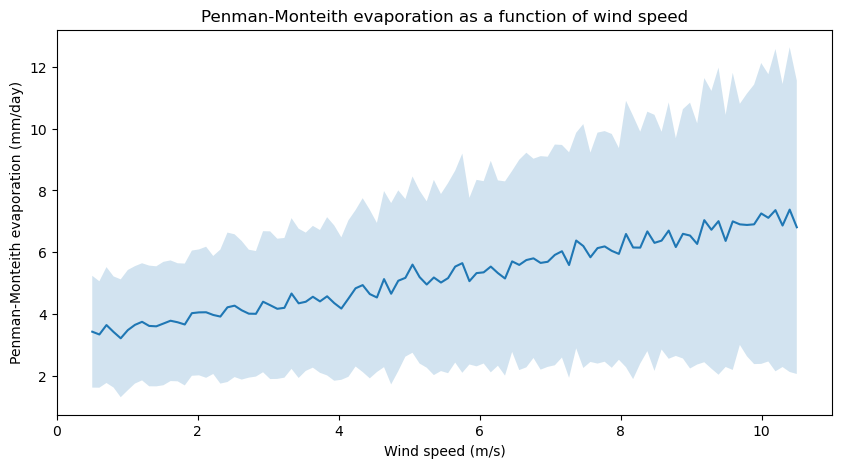

In [86]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(wind_range, res)
# plot the std 
ax.fill_between(wind_range, res - std, res + std, alpha=0.2)

ax.set_xlabel('Wind speed (m/s)')
ax.set_ylabel('Penman-Monteith evaporation (mm/day)')
ax.set_title('Penman-Monteith evaporation as a function of wind speed')
